In [77]:
import pandas as pd
import numpy as np

In [79]:
customers_df = pd.read_csv("Customers.csv")
transactions_df = pd.read_csv("Transactions.csv")

In [81]:
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [85]:
# Convert SignupDate and TransactionDate to datetime format
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

In [87]:
# Preprocessing
agg_transactions = transactions_df.groupby('CustomerID').agg({'TotalValue': ['sum', 'mean'], 'TransactionID': 'count'}).reset_index()
agg_transactions.columns = ['CustomerID', 'TotalSpend', 'AvgTransactionValue', 'TransactionFrequency']

In [89]:
merged_df = customers_df.merge(agg_transactions, on='CustomerID', how='left')

In [91]:
current_date = datetime.now()
merged_df['CustomerTenure'] = (current_date - merged_df['SignupDate']).dt.days

In [93]:
encoder = OneHotEncoder(sparse_output=False, drop='first')
region_encoded = encoder.fit_transform(merged_df[['Region']])
region_encoded_df = pd.DataFrame(region_encoded, columns=encoder.get_feature_names_out(['Region']))

In [95]:
# Combine all features for clustering
features = pd.concat([
    merged_df[['TotalSpend', 'AvgTransactionValue', 'TransactionFrequency', 'CustomerTenure']],
    region_encoded_df
], axis=1)

# Fill missing values (if any) with 0
features.fillna(0, inplace=True)

In [97]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [99]:
# Apply K-Means Clustering for Calculate DB Index
db_indices = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    db_index = davies_bouldin_score(scaled_features, labels)
    db_indices.append(db_index)


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, 

In [101]:
optimal_k = k_range[np.argmin(db_indices)]

In [103]:
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
final_labels = final_kmeans.fit_predict(scaled_features)

C:\Users\hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


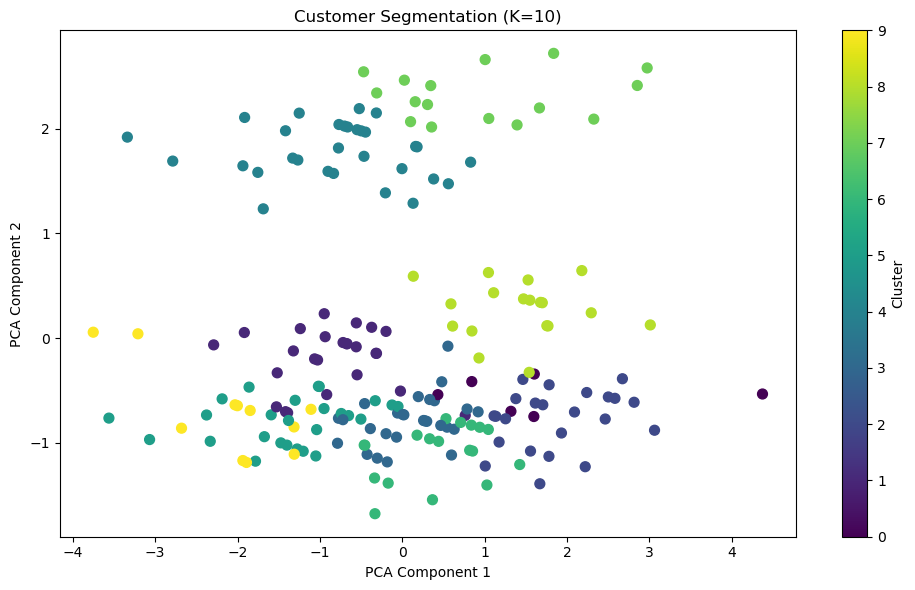

In [105]:
# Visualization using PCA (reduce to 2 dimensions)
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=final_labels, cmap='viridis', s=50)
plt.colorbar(label='Cluster')
plt.title(f'Customer Segmentation (K={optimal_k})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.tight_layout()
plt.show()

In [107]:
clustered_customers = merged_df[['CustomerID']].copy()
clustered_customers['Cluster'] = final_labels

In [109]:
print(f"Optimal number of clusters (K): {optimal_k}")
print(f"Minimum DB Index value: {min(db_indices)}")

Optimal number of clusters (K): 10
Minimum DB Index value: 0.9616777701551934


In [117]:
clustered_customers.sample(7)

,CustomerID,Cluster
35,C0036,4
146,C0147,3
16,C0017,0
166,C0167,5
78,C0079,4
39,C0040,1
30,C0031,3
